In [248]:
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
from icecream import ic

PROJECT_NAME="potato_disease_classification"

In [249]:
IMAGE_SIZE=256 # 256x256 image
BATCH_SIZE=32

In [250]:
dataset=keras.utils.image_dataset_from_directory(directory=r"data",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)


Found 2152 files belonging to 3 classes.


In [251]:
class_names=dataset.class_names

In [252]:
len(dataset) # number of batches

68

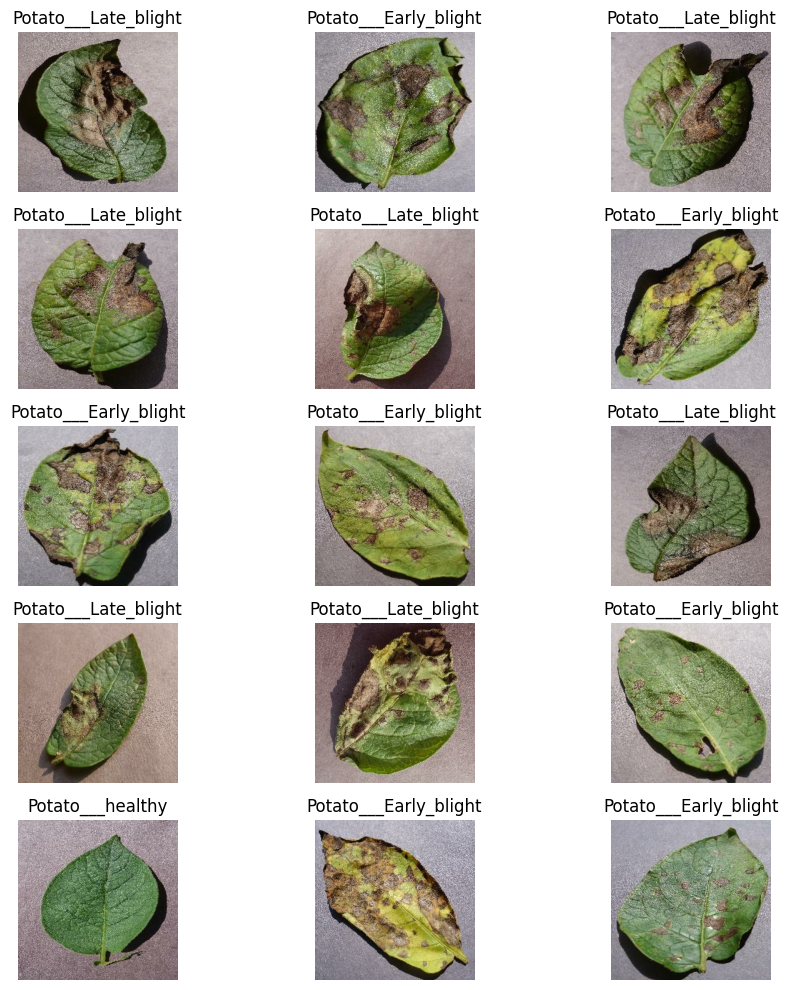

In [253]:
for image_batch,label_batch in dataset.take(1):
    fig,axes=plt.subplots(5,3,figsize=(10,10))
    axes=axes.flatten()
    for i in range(15):
        axes[i].imshow(image_batch[i].numpy().astype("uint8"))
        axes[i].axis("off")
        axes[i].set_title(class_names[label_batch[i]])
    
    plt.tight_layout()
    plt.show()

In [255]:
len(dataset)

68

In [256]:
# 80% for training, 10% for validation, 10% testing


In [257]:
n_batches=len(dataset)

def create_batches(ds,train_ratio,test_ratio):
    n_batches=len(ds)
    
    if train_ratio+test_ratio>1:
        raise Exception("train+test must<=1")
    else:
        train_batch_size=int(train_ratio*n_batches)
        test_batch_size=int(test_ratio*n_batches)
        valid_batch_size=n_batches-train_batch_size-test_batch_size
    
    ic(train_batch_size)
    ic(test_batch_size)
    ic(valid_batch_size)
        
    train_ds=dataset.take(train_batch_size)
    valid_ds=dataset.skip(train_batch_size).take(valid_batch_size)
    test_ds=dataset.skip(train_batch_size+valid_batch_size).take(test_batch_size)
    
    return train_ds,valid_ds,test_ds

train_ds,valid_ds,test_ds=create_batches(dataset,.8,.1)


ic| train_batch_size: 54
ic| test_batch_size: 6
ic| valid_batch_size: 8


In [258]:
len(valid_ds)

8

In [259]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds=valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [262]:
resize_and_rescale= tf.keras.Sequential([keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                                        keras.layers.experimental.preprocessing.Rescaling(1./255)])


In [263]:
data_augmentation= tf.keras.Sequential([keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                        keras.layers.experimental.preprocessing.RandomRotation(.2)])


In [264]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

model = keras.models.Sequential([
    resize_and_rescale,               # Assuming resize_and_rescale is a preprocessing layer
    data_augmentation,                # Assuming data_augmentation is a preprocessing layer
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(activation="relu", units=64),
    keras.layers.Dense(len(class_names), activation="softmax")
])


In [265]:
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_22 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                

In [266]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy']
             )


In [267]:
EPOCHS=30
history= model.fit(train_ds,
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   validation_data=valid_ds)

Epoch 1/30


54/54 [==============================] - 12s 159ms/step - loss: 0.7852 - accuracy: 0.6152 - val_loss: 0.7600 - val_accuracy: 0.7617
Epoch 2/30
54/54 [==============================] - 8s 144ms/step - loss: 0.4632 - accuracy: 0.8247 - val_loss: 0.6340 - val_accuracy: 0.7695
Epoch 3/30
54/54 [==============================] - 8s 151ms/step - loss: 0.2853 - accuracy: 0.8738 - val_loss: 0.4837 - val_accuracy: 0.8359
Epoch 4/30
54/54 [==============================] - 8s 152ms/step - loss: 0.2072 - accuracy: 0.9253 - val_loss: 0.2465 - val_accuracy: 0.8750
Epoch 5/30
54/54 [==============================] - 8s 154ms/step - loss: 0.1681 - accuracy: 0.9410 - val_loss: 0.3114 - val_accuracy: 0.8789
Epoch 6/30
54/54 [==============================] - 8s 154ms/step - loss: 0.1586 - accuracy: 0.9439 - val_loss: 0.2263 - val_accuracy: 0.9297
Epoch 7/30
54/54 [==============================] - 8s 157ms/step - loss: 0.1536 - accuracy: 0.9427 - val_loss: 0.1904 - val_accuracy: 0.9258
Epoch 8/30
54/54

In [268]:
history.history

{'loss': [0.785171389579773,
  0.46316561102867126,
  0.28530552983283997,
  0.20719312131404877,
  0.168069526553154,
  0.15862028300762177,
  0.15362010896205902,
  0.11198264360427856,
  0.10975488275289536,
  0.15010830760002136,
  0.0976465716958046,
  0.08901532739400864,
  0.08035403490066528,
  0.0658540427684784,
  0.10628873109817505,
  0.10451288521289825,
  0.08375568687915802,
  0.0739852637052536,
  0.05985618010163307,
  0.07010319083929062,
  0.04437469691038132,
  0.03358711674809456,
  0.039685409516096115,
  0.07072971016168594,
  0.0477013885974884,
  0.04274997487664223,
  0.08479958772659302,
  0.07786937803030014,
  0.055704377591609955,
  0.02645624428987503],
 'accuracy': [0.6151620149612427,
  0.8246527910232544,
  0.8738425970077515,
  0.9253472089767456,
  0.9409722089767456,
  0.9438657164573669,
  0.9427083134651184,
  0.9606481194496155,
  0.9554398059844971,
  0.9432870149612427,
  0.9646990895271301,
  0.9664351940155029,
  0.9681712985038757,
  0.97627

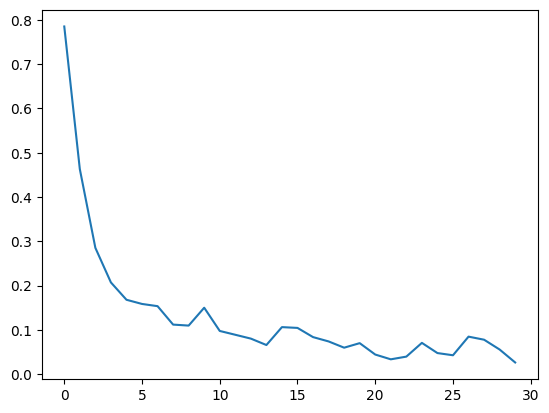

In [269]:
    plt.plot(history.history["loss"])

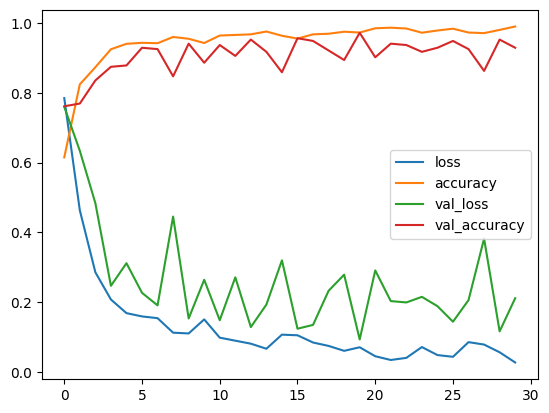

In [270]:
for i,x in enumerate(history.history):
    plt.plot(history.history[x],label=x)

plt.legend()

In [271]:
model.evaluate(test_ds)

6/6 [==============================] - 1s 25ms/step - loss: 0.1652 - accuracy: 0.9464


[0.16518212854862213, 0.9464285969734192]

In [272]:
# Visualising our predictions

In [273]:
for image_batch,label_batch in test_ds.take(1):
    print(len(image_batch))
    predictions=model.predict(image_batch)
    predicted_class_names=list(map(lambda x:class_names[np.argmax(x)],predictions))
    
    
    for i,j in zip(label_batch,predicted_class_names):
        print(class_names[i],j)

8
1/1 [==============================] - 1s 771ms/step
Potato___Early_blight Potato___Early_blight
Potato___Early_blight Potato___Early_blight
Potato___Late_blight Potato___Late_blight
Potato___Early_blight Potato___Early_blight
Potato___healthy Potato___healthy
Potato___Early_blight Potato___Early_blight
Potato___Late_blight Potato___Late_blight
Potato___Early_blight Potato___Early_blight


In [274]:
def predict_single_image(img,model):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0) # create batch
    
    prediction_result=model.predict(img_array)
    
    predicted_label=np.argmax(prediction_result)
    confidence=round(np.max(prediction_result)*100,2)
    return predicted_label,confidence

    


1/1 [==============================] - 0s 31ms/step


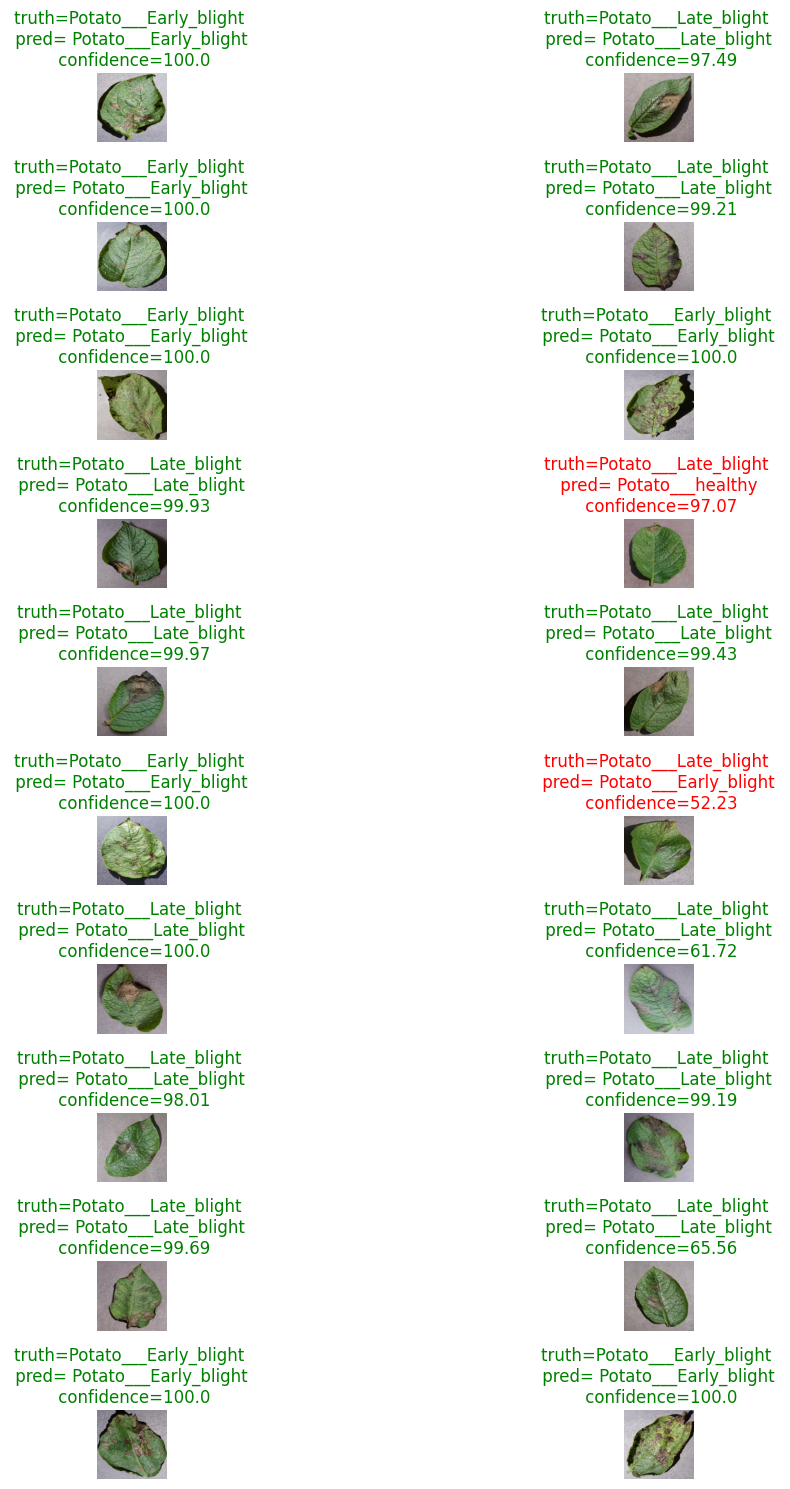

In [275]:
for images,labels in test_ds.take(1):
    fig,axes=plt.subplots(nrows=10,ncols=2,figsize=(15,15))
    axes=axes.flatten()
    
    for i in range(20):
        
        img=images[i].numpy().astype("uint")
        true_label=labels[i]
        true_label_class=class_names[true_label]
        
        pred_label,confidence=predict_single_image(img,model)
        pred_label_class=class_names[pred_label]
        
        if pred_label_class==true_label_class:
            c="green"
        else:
            c="red"
        #OUTPUT
        axes[i].imshow(img)
        axes[i].set_title(f"truth={true_label_class} \n pred= {pred_label_class} \n confidence={confidence}",color=c)
        axes[i].axis("off")
      
    plt.tight_layout()
    plt.show()
    

In [276]:
from datetime import datetime
model_version=datetime.now().strftime("%y%m%d.%H%M")
print(model_version)
model.save(f"../models/{model_version}- {PROJECT_NAME}")

240814.0406


INFO:tensorflow:Assets written to: ../models/240814.0406- potato_disease_classification\assets


INFO:tensorflow:Assets written to: ../models/240814.0406- potato_disease_classification\assets
